In [28]:
#%conda install -c conda-forge yfinance matplotlib tensorflow scikit-learn
#%pip install pandas scikit-learn yfinance matplotlib tensorflow
import json
import numpy as np
import os
import locale
import pandas as pd
import tensorflow as tf
import yaml

from sklearn.preprocessing import MinMaxScaler

# Data Source
import yfinance as yf
import matplotlib.pyplot as plt

from stock_modules.stock_io import (read_tickers_from_excel,
                                    get_histories)

from stock_modules.stock_ml import  create_direction_prediction_model_rnn, create_updown_prediction_model_rnn, create_updown_prediction_model_dense

from src.clean_data_stl import clean_data_stl

# Figures
from stock_modules.stock_plot import plot_numpy_arr_cols
if not os.path.exists("./figures"):
    os.mkdir("./figures")

In [29]:
with open("config.yml", 'r') as file:
    config = yaml.safe_load(file)

MODEL = 'rnnlong'
config = config[MODEL]

ENCODING = locale.getpreferredencoding()
DF_PATH = config['DF_PATH']
HISTORY_ARRAY_PATH = config['HISTORY_ARRAY_PATH']
MODEL_PATH = config['MODEL_PATH']
SELECTED_TICKERS_PATH = config['SELECTED_TICKERS_PATH']

TEST_FRAC = config['TEST_FRAC']
PREDICT_PRICES = config['PREDICT_PRICES']

MHOURS = config['MHOURS']
OUTPUT_SCALE = eval(config['OUTPUT_SCALE'])


RENEW_MODEL = config['RENEW_MODEL']
PATIENCE = config['PATIENCE']
EPOCHS = config['EPOCHS']
BATCH_SIZE = config['BATCH_SIZE']

RECURSE_TO = config['RECURSE_TO']

LOSS_FUN_NAME = config['LOSS_FUN_NAME']
LOSS_FUN = getattr(tf.keras.losses, LOSS_FUN_NAME, None)

DAY_LENGTH = config['DAY_LENGTH']
WEEK_LENGTH = config['WEEK_LENGTH']


SELECTED_TICKERS = json.load(open(SELECTED_TICKERS_PATH, "r", encoding=ENCODING))
DATAFRAME = pd.read_csv(DF_PATH, encoding=ENCODING)
DATAFRAME.set_index("date", inplace=True)
HAS_TIMEDELTA = "Time Delta" in DATAFRAME.columns
# ind transformation tells the label of each index in the np_arr_test
IND_CONVERSION = {i: ticker for i, ticker in enumerate(DATAFRAME.columns) if ticker in SELECTED_TICKERS}
IND_CONVERSION = {i: ticker for i, ticker in enumerate(IND_CONVERSION.values())}
print("Selected tickers: \n", SELECTED_TICKERS)
print("Dataframe shape: ", DATAFRAME.shape)
print(f"Index conversion: \n")
for k, v in IND_CONVERSION.items():
    print(f"{k}: {v}")
print(f"Using Time Delta: {HAS_TIMEDELTA}")

Selected tickers: 
 ['ALBBV.HE', 'CGCBV.HE', 'EQV1V.HE', 'KNEBV.HE', 'ORNBV.HE', 'OLVAS.HE', 'DETEC.HE', 'PON1V.HE', 'ORNAV.HE', 'VALMT.HE', 'NESTE.HE', 'HUH1V.HE', 'REG1V.HE', 'VAIAS.HE']
Dataframe shape:  (4389, 14)
Index conversion: 

0: REG1V.HE
1: NESTE.HE
2: ORNBV.HE
3: KNEBV.HE
4: OLVAS.HE
5: HUH1V.HE
6: DETEC.HE
7: ORNAV.HE
8: CGCBV.HE
9: VAIAS.HE
10: ALBBV.HE
11: VALMT.HE
12: EQV1V.HE
13: PON1V.HE
Using Time Delta: False


In [30]:
LOSS_FUN

<function keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=0.0, axis=-1)>

In [31]:
DATAFRAME = clean_data_stl(df=DATAFRAME,
                           DAY_LENGTH=DAY_LENGTH,
                           WEEK_LENGTH=WEEK_LENGTH)

/home/akseli/Documents/University/LUT/stonk-prediction/src/clean_data_stl.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if resid[i] < lower_bound or resid[i] > upper_bound:
/home/akseli/Documents/University/LUT/stonk-prediction/src/clean_data_stl.py:31: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  cleaned_data[i] = np.mean(cleaned_data[max(0, i - 1):i + 2])


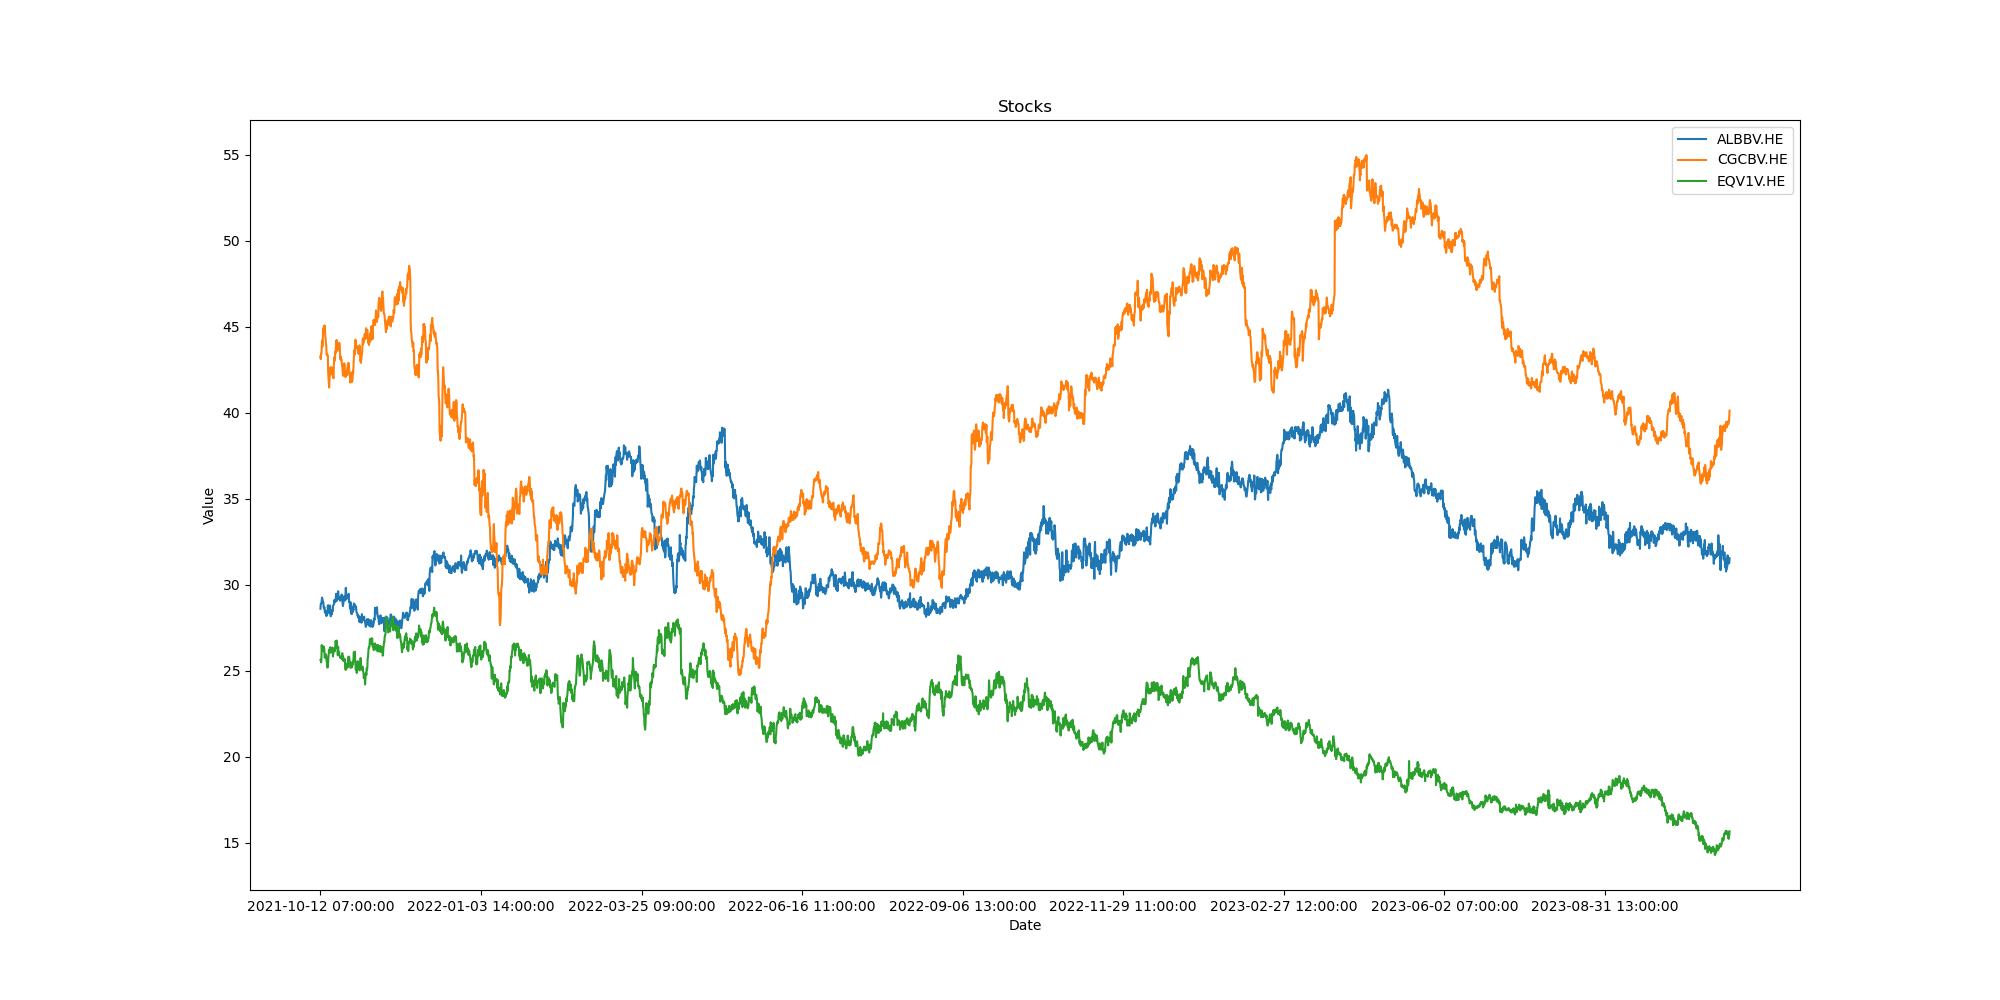

In [32]:
# Show values or not
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Stocks")
ax.set_xlabel("Date")
ax.set_ylabel("Value")
for ticker in SELECTED_TICKERS[:3]:
    ax.plot(DATAFRAME.index, DATAFRAME[ticker], label=ticker)
# Change xticks
ax.set_xticks(DATAFRAME.index[::500])
ax.legend()
plt.show()

In [33]:
# If we are predicting the next price, we just minmax scale the data
if PREDICT_PRICES:
    scaler = MinMaxScaler()
    test_begin_idx = int(DATAFRAME.shape[0] * (1 - TEST_FRAC))

    scaler.fit(DATAFRAME.iloc[:test_begin_idx, :])
    transformed_df = pd.DataFrame(scaler.transform(DATAFRAME), columns=DATAFRAME.columns, index=DATAFRAME.index)
    transformed_np_arr = transformed_df.to_numpy()

    def inverse_transform(df):
        if isinstance(df, pd.DataFrame):
            return pd.DataFrame(scaler.inverse_transform(df), columns=df.columns, index=df.index)
        elif isinstance(df, np.ndarray):
            return scaler.inverse_transform(df)
# If we are predicting the up/down, we create a dataframe where we subtract the previous value from the current value
else:
    # Do not diff the Time Delta column
    df = DATAFRAME.copy()
    if HAS_TIMEDELTA:
        td_col = df["Time Delta"]
        df.drop("Time Delta", axis=1, inplace=True)
    transformed_df = df.diff()
    # The first row is NaN, so lets copy the second row there
    transformed_df.iloc[0, :] = transformed_df.iloc[1, :]
    # Add back the Time Delta column
    if HAS_TIMEDELTA:
        transformed_df["Time Delta"] = td_col
        # Make Time Delta the first column
        cols = transformed_df.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        transformed_df = transformed_df[cols]
    transformed_np_arr = transformed_df.to_numpy()

    def inverse_transform(df):
        return df

#print("Transformed df: \n", transformed_df.shape)
print("Transformed df shape: ", transformed_df.shape)

Transformed df shape:  (4389, 14)


In [34]:
# Reload modules
%load_ext autoreload
%autoreload 2

from stock_modules.stock_transform import create_batch_xy
MHOURS = 48
CHANGE_THRESHOLD = 0.002
def update_global_mhours(new_mhours):
    global MHOURS, X_train, Y_train, X_test, Y_test, X_og, Y_og
    MHOURS = new_mhours
    print(f"MHOURS is now {MHOURS}")
    print(f"Recalculating X and Y data...")
    # Batch X data into sequences of length MHOURS (from T to T+n)
    # Label Y data as 0, 1, 2 for down, flat, up
    # We give the data in the original format, so that the labels can be calculated
    _, Y = create_batch_xy(MHOURS,
                        DATAFRAME,
                        overlap=True,
                        y_updown=False,
                        y_direction=True,
                        threshold=CHANGE_THRESHOLD,
                        to_onehot=True,
                        create_labels=True,
                        )

    # Here instead, we can give the differenced data, because we don't need to calculate the labels
    X,_ = create_batch_xy(MHOURS,
                            transformed_df,
                            overlap=True,
                            create_labels=False,
                            )
    
    rand_indicies = np.random.permutation(X.shape[0])
    X = X[rand_indicies,:,:]
    Y = Y[rand_indicies,:,:]

    # Swap 2nd and 3rd axes in Y to reshape it to (n_samples, 3,nstocks)
    Y = np.swapaxes(Y, 1, 2)

    X_og = X.copy()
    Y_og = Y.copy()

    print(f"X shape: {X.shape}")
    print(f"Y shape: {Y.shape}")

    test_sz = int(X.shape[0] * TEST_FRAC)

    # Split the data into train and test sets
    X_train = X[:-test_sz,:,:]
    Y_train = Y[:-test_sz,:,:]
    X_test = X[-test_sz:,:,:]
    Y_test = Y[-test_sz:,:,:]

update_global_mhours(MHOURS)

print(f"One input shape: {X_train[0].shape}")
print(f"One output shape: {Y_train[0].shape}")

print(f"Example input: \n {X_train[0]}")
print(f"Example output: \n {Y_train[0]}")

# Count the number of ups/downs/flats in Y_train
print(f"Y_train: {Y_train}")
print(f"Number of down classes: {np.sum(Y_train[:,0,:])}")
print(f"Number of flat classes: {np.sum(Y_train[:,1,:])}")
print(f"Number of up classes: {np.sum(Y_train[:,2,:])}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
MHOURS is now 48
Recalculating X and Y data...
[[54.87174884 43.29280547 35.40613899 ... 37.01443791 25.63172824
  41.89626133]
 [55.60877916 43.46801905 35.47060104 ... 37.10697098 25.60087567
  42.06552863]
 [55.95882307 43.95465168 35.5499624  ... 37.09667756 25.48823379
  42.61174554]
 ...
 [23.19303882 32.17720803 36.25168083 ... 22.44172726 15.51573439
  23.81257465]
 [23.60249669 32.19631031 36.31031811 ... 22.54635739 15.43261764
  23.59032823]
 [23.73111772 32.60939712 36.45596729 ... 22.67189576 15.6643468
  23.45387677]]

            Batched 'histories_arr' ((4389, 14)) to 'X'
            ((4341, 48, 14)) and 'Y' ((4341, 14, 3))
            
[[ 0.73703033  0.17521357  0.06446205 ...  0.09253307 -0.03085258
   0.16926731]
 [ 0.73703033  0.17521357  0.06446205 ...  0.09253307 -0.03085258
   0.16926731]
 [ 0.3500439   0.48663263  0.07936136 ... -0.01029342 -0.11264187
   0.54621691]
 ...
 [ 

In [35]:
from stock_modules.stock_ml import (SkipTDLoss, MultiSoftmaxLoss, MultiAccuracy)
LOSS_FUN = MultiSoftmaxLoss() if not HAS_TIMEDELTA else SkipTDLoss(MultiSoftmaxLoss())


def get_direction_pred_model(hp):
    """ Returns a model that predicts the direction of the stock price.
    """
    # Input shape is (nhours, nstocks)
    input_shape = (MHOURS, X_train.shape[2])
    # Output shape is (3, nstocks)
    output_shape = (3, X_train.shape[2])

    inputs = tf.keras.layers.Input(shape=input_shape)

    nlstm_layers = hp.Int("nlstm_layers", min_value=1, max_value=3, step=1)
    lstm_units = hp.Int("lstm_units", min_value=32, max_value=128, step=32)
    use_bidirectional = hp.Boolean("use_bidirectional")
    # Add LSTM layers
    x = inputs
    x = tf.keras.layers.SimpleRNN(lstm_units, return_sequences=True)(x)

    # Flatten the output
    ndense_layers = hp.Int("ndense_layers", min_value=1, max_value=3, step=1)
    dense_units = hp.Int("dense_units", min_value=32, max_value=128, step=32)
    dropout_rate = hp.Float("dropout_rate", min_value=0.1, max_value=0.5, step=0.1)
    x = tf.keras.layers.Flatten()(x)
    for i in range(ndense_layers):
        x = tf.keras.layers.Dense(dense_units, activation="relu")(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    # Output layer
    outputs = tf.keras.layers.Dense(output_shape[0]*output_shape[1], activation="linear")(x)
    outputs = tf.keras.layers.Reshape(output_shape)(outputs)
    # apply aoftmax to the columns
    outputs = tf.keras.layers.Softmax(axis = 1)(outputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    use_amsgrad = hp.Boolean("use_amsgrad")
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(amsgrad=use_amsgrad),
                    loss=LOSS_FUN,
                    metrics=[MultiAccuracy(has_timedelta=HAS_TIMEDELTA)])
    return model

In [36]:
%load_ext autoreload
%autoreload 2
# Tune the hyperparameters
import keras_tuner as kt

PATIENCE = 20
EPOCHS = 200
BATCH_SIZE = 256
DO_HYPERPARAMETER_TUNING = False

# Create a callback to stop training early
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                patience=PATIENCE,
                                                restore_best_weights=True)

if DO_HYPERPARAMETER_TUNING:
    # Create a tuner
    objective = kt.Objective("val_multi_accuracy", direction="max")
    tuner = kt.Hyperband(get_direction_pred_model,
                        objective=objective,
                        max_epochs=EPOCHS,
                        factor=5,
                        directory=MODEL_PATH,
                        project_name=f"direction_prediction_{MHOURS}"
                        )

    # Train the model
    tuner.search(X_train,
                Y_train,
                epochs=200,
                batch_size=BATCH_SIZE,
                validation_split=0.2,
                callbacks=[early_stopping])

    # Get the best model
    best_model = tuner.get_best_models(num_models=1)[0]
    best_model.summary()
    # save the model
    best_model.save("best_model.h5")
    model = best_model
else:
    from stock_modules.stock_ml import create_direction_prediction_model
    # Train a model once
    model = create_direction_prediction_model_rnn(MHOURS, X_train.shape[2])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss=LOSS_FUN,
                    metrics=[MultiAccuracy(has_timedelta=HAS_TIMEDELTA)]
                    )
    print(model.summary())
    
    model.fit(X_train,
              Y_train, 
              epochs=EPOCHS,
              batch_size=BATCH_SIZE, 
              validation_split=0.2,
              callbacks=[early_stopping]
              )

# Evaluate the model
loss, acc = model.evaluate(X_test, Y_test)
print(f"Test loss: {loss}, test accuracy: {acc}")

Y_pred = model.predict(X_test)
if HAS_TIMEDELTA:
    Y_pred = Y_pred[:,1:]



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 48, 14)]          0         
                                                                 
 batch_normalization_7 (Batc  (None, 48, 14)           56        
 hNormalization)                                                 
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 48, 64)            5056      
                                                                 
 flatten_7 (Flatten)         (None, 3072)              0         
                                                                 
 dense_14 (Dense)            (None, 64)                196672    
                                                                 
 dense_15 (Dense)            (None, 4

/home/akseli/anaconda3/envs/adaml/lib/python3.9/site-packages/keras/engine/training.py:2448: UserWarning: Metric MultiAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


11/11 [==============================] - 10s 326ms/step - loss: 1.1321 - multi_accuracy_7: 0.3372 - val_loss: 1.1047 - val_multi_accuracy_7: 0.3385
Epoch 2/200
11/11 [==============================] - 2s 189ms/step - loss: 1.0444 - multi_accuracy_7: 0.3894 - val_loss: 1.1025 - val_multi_accuracy_7: 0.3874
Epoch 3/200
11/11 [==============================] - 3s 242ms/step - loss: 1.0006 - multi_accuracy_7: 0.4203 - val_loss: 1.1047 - val_multi_accuracy_7: 0.4171
Epoch 4/200
11/11 [==============================] - 2s 219ms/step - loss: 0.9623 - multi_accuracy_7: 0.4409 - val_loss: 1.1103 - val_multi_accuracy_7: 0.4377
Epoch 5/200
11/11 [==============================] - 2s 202ms/step - loss: 0.9256 - multi_accuracy_7: 0.4571 - val_loss: 1.1179 - val_multi_accuracy_7: 0.4540
Epoch 6/200
11/11 [==============================] - 3s 238ms/step - loss: 0.8906 - multi_accuracy_7: 0.4708 - val_loss: 1.1272 - val_multi_accuracy_7: 0.4679
Epoch 7/200
11/11 [==============================] - 2s 1

In [37]:
print("Y_pred: \n", Y_pred)
print("Y_test: \n", Y_test)

# Calculate the accuracy of up-down-flat predictions
# So predict the up/down of each stock, at each time on the test data (Y_pred)
# and compare it to the true values (Y_test)
for stock_idx in range(Y_pred.shape[2] -1 if HAS_TIMEDELTA else Y_pred.shape[2]):
    # Get the up/down/flat predictions for the stock
    direction_preds = Y_pred[:,:,stock_idx]
    #print(f"direction_preds: \n {direction_preds}")
    # Get the true up/down/flat values for the stock
    direction_true = Y_test[:,:,stock_idx]
    # Get the predicted up/down/flat class
    direction_preds = np.argmax(direction_preds, axis=1)
    # Get the true up/down/flat class
    direction_true = np.argmax(direction_true, axis=1)
    # Calculate the accuracy
    accuracy = np.sum(direction_preds == direction_true) / len(direction_preds)
    print(f"Up/Down/Flat accuracy for stock {IND_CONVERSION[stock_idx]}: {accuracy}")


Y_pred: 
 [[[0.277206   0.33333334 0.38263944 ... 0.33255324 0.33355266 0.34942412]
  [0.277206   0.33333334 0.3086803  ... 0.3348935  0.34969005 0.32528797]
  [0.44558796 0.33333334 0.3086803  ... 0.33255324 0.31675732 0.32528797]]

 [[0.29841006 0.37235948 0.40655145 ... 0.32858074 0.37523192 0.29307675]
  [0.4031799  0.31235728 0.2990134  ... 0.3428385  0.29664493 0.29307675]
  [0.29841006 0.3152832  0.29443514 ... 0.32858074 0.32812312 0.41384646]]

 [[0.42058432 0.3826132  0.31760684 ... 0.39245492 0.38370392 0.31071308]
  [0.2897078  0.3086934  0.36478636 ... 0.26389435 0.33292368 0.31071308]
  [0.2897078  0.3086934  0.31760684 ... 0.34365073 0.2833724  0.37857386]]

 ...

 [[0.3618866  0.33333334 0.44888198 ... 0.33333334 0.33333334 0.22947711]
  [0.3190567  0.33333334 0.275559   ... 0.33333334 0.33333334 0.23307312]
  [0.3190567  0.33333334 0.275559   ... 0.33333334 0.33333334 0.5374497 ]]

 [[0.3444824  0.33333334 0.3270972  ... 0.34817973 0.3609737  0.32346255]
  [0.34230727 

In [38]:

from invest_strategies import (calculate_optimal_invest_strategy,
                               calculate_profit_on_invest_strategy,
                               strategy_mask_from_price_model,
                               strategy_mask_from_updown_model,
                               strategy_mask_from_direction_model)

# Calculate profit by optimal strategy (theoretical) vs using model to predict
test_sz = int(DATAFRAME.shape[0] * TEST_FRAC)
df_test = DATAFRAME.iloc[-test_sz:,:].copy()
if HAS_TIMEDELTA:
    df_test.drop("Time Delta", axis=1, inplace=True)
np_arr_test = df_test.to_numpy()
print("np_arr_test data shape: ", np_arr_test.shape)

optimal_trading_mask = calculate_optimal_invest_strategy(np_arr_test)
print(f"Optimal mask 4th stock: \n {optimal_trading_mask[:,2]}")
profit_optimal = calculate_profit_on_invest_strategy(np_arr_test, optimal_trading_mask)
print(f"Optimal strategy matrix shape: {optimal_trading_mask.shape}")
print(f"Profit by optimal strategy on test data: {profit_optimal}")

# To calculate the mask for the model, we need to give the data in the same format as it was trained in
transformed_df_test = transformed_df.iloc[-test_sz:,:]
transformed_np_arr_test = transformed_df_test.to_numpy()
print("transformed_np_arr_test data shape: ", transformed_np_arr_test.shape)
print(transformed_np_arr_test[0:2,:])
prediction_trading_mask = strategy_mask_from_direction_model(transformed_np_arr_test, MHOURS, model)

if HAS_TIMEDELTA:
    prediction_trading_mask = prediction_trading_mask[:,1:]

print(f"Prediction mask 2nd stock: \n {prediction_trading_mask[:,2]}")
if HAS_TIMEDELTA:
    profit_pred_model = calculate_profit_on_invest_strategy(np_arr_test[:,1:], prediction_trading_mask)
else:
    profit_pred_model = calculate_profit_on_invest_strategy(np_arr_test, prediction_trading_mask)
print(f"Prediction strategy matrix shape: {prediction_trading_mask.shape}")
print(f"Profit by predicting the next hour using the model: {profit_pred_model}")

np_arr_test data shape:  (877, 14)
Optimal mask 4th stock: 
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

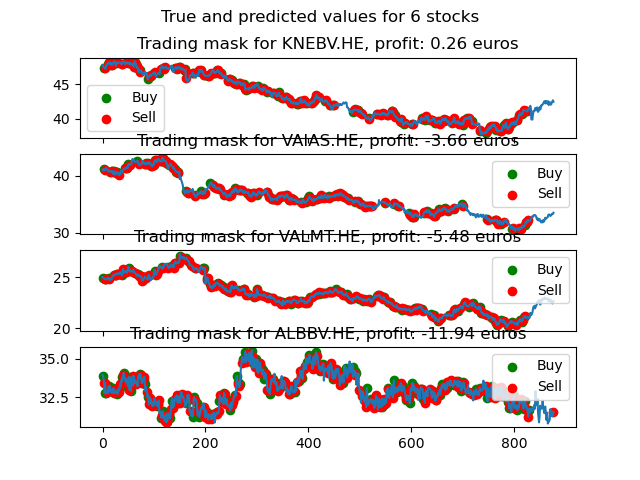

(<Figure size 640x480 with 4 Axes>,
 array([<Axes: title={'center': 'Trading mask for KNEBV.HE, profit: 0.26 euros'}>,
        <Axes: title={'center': 'Trading mask for VAIAS.HE, profit: -3.66 euros'}>,
        <Axes: title={'center': 'Trading mask for VALMT.HE, profit: -5.48 euros'}>,
        <Axes: title={'center': 'Trading mask for ALBBV.HE, profit: -11.94 euros'}>],
       dtype=object))

In [39]:
%matplotlib widget
from stock_modules.stock_plot import plot_strategy_based_on_predictions,plot_mask_and_data
stock_indices = np.random.choice(np.arange(len(IND_CONVERSION)), 4, replace=False)
part_mask = prediction_trading_mask[:,stock_indices]

if HAS_TIMEDELTA:
    part_price = np_arr_test[:,1:][:,stock_indices]
else:
    part_price = np_arr_test[:,stock_indices]
ind_conversion = {si : IND_CONVERSION[i] for si, i in enumerate(stock_indices)}
plot_mask_and_data(part_mask, part_price, ind_conversion)